
<a href="https://colab.research.google.com/github/NeuroDesk/example-notebooks/blob/main/functional_imaging/AFNI_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Google Colab"/>   </a>

# Preprocessing with AFNI

Author: Monika Doerig

Citation:

__Andy's Brain Book:__
- This AFNI example is based on the [AFNI Tutorial: Commands and Preprocessing](https://andysbrainbook.readthedocs.io/en/latest/AFNI/AFNI_Short_Course/AFNI_04_Preprocessing.html)  from Andy’s Brain Book (Jahn, 2022. [doi:10.5281/zenodo.5879293](https://zenodo.org/records/5879294))

__Data from OpenNeuro:__ Flanker Dataset

- Kelly AMC and Uddin LQ and Biswal BB and Castellanos FX and Milham MP (2018). Flanker task (event-related). [OpenNeuro Dataset ds000102](https://openneuro.org/datasets/ds000102/versions/00001/). [Dataset] doi: null
- Kelly AM, Uddin LQ, Biswal BB, Castellanos FX, Milham MP. Competition between functional brain networks mediates behavioral variability. Neuroimage. 2008 Jan 1;39(1):527-37. doi: [10.1016/j.neuroimage.2007.08.008](https://doi.org/10.1016/j.neuroimage.2007.08.008). Epub 2007 Aug 23. PMID: 17919929.
- Mennes, M., Kelly, C., Zuo, X.N., Di Martino, A., Biswal, B.B., Castellanos, F.X., Milham, M.P. (2010). Inter-individual differences in resting-state functional connectivity predict task-induced BOLD activity. Neuroimage, 50(4):1690-701. doi: [10.1016/j.neuroimage.2010.01.002](https://doi.org/10.1016/j.neuroimage.2010.01.002). Epub 2010 Jan 15. Erratum in: Neuroimage. 2011 Mar 1;55(1):434
- Mennes, M., Zuo, X.N., Kelly, C., Di Martino, A., Zang, Y.F., Biswal, B., Castellanos, F.X., Milham, M.P. (2011). Linking inter-individual differences in neural activation and behavior to intrinsic brain dynamics. Neuroimage, 54(4):2950-9. doi: [10.1016/j.neuroimage.2010.10.046](https://doi.org/10.1016/j.neuroimage.2010.10.046)

## Setup Neurodesk

In [1]:
%%capture
import os
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  os.environ["LD_PRELOAD"] = "";
  os.environ["APPTAINER_BINDPATH"] = "/content,/tmp,/cvmfs"
  os.environ["MPLCONFIGDIR"] = "/content/matplotlib-mpldir"
  os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

  !curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
  !chmod +x googlecolab_setup.sh
  !./googlecolab_setup.sh

  os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

In [2]:
# Output CPU information:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: GenuineIntel
model name	: Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz


### Load packages

In [3]:
import lmod
await lmod.load('afni/21.2.00')
await lmod.list()

['afni/21.2.00']

### Install tcsh

In [4]:
%%capture
!sudo apt update; sudo apt install tcsh

Check the installation:

In [5]:
%%script tcsh
set var = "hello from tcsh"
echo $var

hello from tcsh


### Import Python Modules

In [6]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from ipyniivue import NiiVue
from IPython.display import display
from ipywidgets import VBox, Dropdown
import ipywidgets as widgets

## Data preparation

In [7]:
PATTERN = "sub-08"
!datalad install https://github.com/OpenNeuroDatasets/ds000102.git
!cd ds000102 && datalad get $PATTERN

Cloning:   0%|                             | 0.00/2.00 [00:00<?, ? candidates/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0%|                               | 0.00/27.0 [00:00<?, ? Objects/s]
                                                                                
Compressing:   0%|                            | 0.00/23.0 [00:00<?, ? Objects/s]
                                                                                
Receiving:   0%|                             | 0.00/2.15k [00:00<?, ? Objects/s]
                                                                                
Resolving:   0%|                                | 0.00/537 [00:00<?, ? Deltas/s]
[INFO   ] scanning for unlocked files (this may take some time)                 
[INFO   ] Remote origin not usable by git-annex; setting annex-ignore 
[INFO   ] access to 1 dataset sibling s3-PRIVATE not auto-enabled, enable with:
| 		datalad siblings -d "/

The data is structured in BIDS format:

In [8]:
!tree -L 4 ds000102

ds000102
├── CHANGES
├── README
├── T1w.json
├── dataset_description.json
├── derivatives
│   └── mriqc
│       ├── aMRIQC.csv -> ../../.git/annex/objects/Q4/jv/MD5E-s14180--3addf0456b803b7c5ec5147481ecdd62.csv/MD5E-s14180--3addf0456b803b7c5ec5147481ecdd62.csv
│       ├── anatomical_group.pdf -> ../../.git/annex/objects/6m/q9/MD5E-s98927--d11151f65ae061833e7fd4373adfec3f.pdf/MD5E-s98927--d11151f65ae061833e7fd4373adfec3f.pdf
│       ├── anatomical_sub-01.pdf -> ../../.git/annex/objects/K3/7x/MD5E-s2747349--5d40f2a54fb4194ac4a79f0295ff51c0.pdf/MD5E-s2747349--5d40f2a54fb4194ac4a79f0295ff51c0.pdf
│       ├── anatomical_sub-02.pdf -> ../../.git/annex/objects/Kx/Kv/MD5E-s2803965--56f6b768362bd9b7f0ef501b8cb6dde6.pdf/MD5E-s2803965--56f6b768362bd9b7f0ef501b8cb6dde6.pdf
│       ├── anatomical_sub-03.pdf -> ../../.git/annex/objects/kx/g5/MD5E-s2809843--e90d7a4859ed4be986b55e23f93ca89d.pdf/MD5E-s2809843--e90d7a4859ed4be986b55e23f93ca89d.pdf
│       ├── anatomical_sub-04.pdf -> ../../.git/annex/ob

### Inspecting the anatomical and functional images

To use the AFNI graphical user interface, you would type:
```javascript
afni sub-08_T1w.nii.gz
```
We will use ipyniivue to look at the data:

Many of the quality checks for the functional images are similar to those for the anatomical images. Look out for excessively bright or dark spots in the grey or white matter, as well as any image distortions, such as abnormal stretching or warping. A common area where slight distortion may occur is in the orbitofrontal region, just above the eyeballs.

Additionally, it’s important to check for excessive motion during the scan.

In [9]:
anat_image = './ds000102/sub-08/anat/sub-08_T1w.nii.gz'
func1_image = './ds000102/sub-08/func/sub-08_task-flanker_run-1_bold.nii.gz'
func2_image = './ds000102/sub-08/func/sub-08_task-flanker_run-2_bold.nii.gz'

In [10]:
# anatomical image
nv = NiiVue()
nv.load_volumes([{"path": anat_image}])
nv

NiiVue(height=300)

In [11]:
# functional run 1
nv = NiiVue()
nv.load_volumes([{"path": func1_image}])
nv

NiiVue(height=300)

## AFNI Commands and Preprocessing

We will be working with the data from subject sub-08. First, we'll introduce basic AFNI commands. Then, we’ll create a processing script using ```afni_proc.py```, which automates the entire preprocessing workflow. AFNI also provides graphical user interfaces (GUIs), such as ```uber_subject.py``` and ```uber_ttest.py``` (for group analysis), which help build processing scripts by combining many commands in the correct order. However, since GUIs cannot be used within a Jupyter Notebook environment, we will focus on writing the scripts directly.

After setting up the automated script, we'll walk through each preprocessing step individually and discuss how to check data quality before and after each step.

- 1: AFNI Commands
 
- 2: Preprocessing with ```afni_prc.py``` 
    - Registration and Normalization 
    - Alignment and Motion Correction
    - Smoothing
    - Masking and Scaling
    - Checking Preprocessing

### 1. AFNI commands
AFNI commands typicallly require at least one argument, or input, and they also usually require you to specify what to call the output of the command.

Let’s take skull-stripping, for example - a common preprocessing step that removes the skull from the brain. The AFNI command to do this step is called 3dSkullStrip. Use the ```-h``` flag to print the help page.

In [12]:
!3dSkullStrip -h


Usage: A program to extract the brain from surrounding.
  tissue from MRI T1-weighted images. 
  The simplest command would be:
        3dSkullStrip <-input DSET>

  Also consider the script @SSwarper, which combines the use of
  3dSkullStrip and nonlinear warping to an MNI template to produce
  a skull-stripped dataset in MNI space, plus the nonlinear warp
  that can used to transform other datasets from the same subject
  (e.g., EPI) to MNI space. (This script only applies to human brain
  images.)

  The fully automated process consists of three steps:
  1- Preprocessing of volume to remove gross spatial image 
  non-uniformity artifacts and reposition the brain in
  a reasonable manner for convenience.
    ** Note that in many cases, using 3dUnifize before **
    ** using 3dSkullStrip will give better results.    **
  2- Expand a spherical surface iteratively until it envelopes
  the brain. This is a modified version of the BET algorithm:
     Fast robust automated brain extractio

One of AFNI’s major advantages is the quality of its documentation and help resources. Each command's usage is thoroughly described, and the purpose behind various options is clearly explained. Example commands are provided to illustrate how to handle different situations — for instance, if too much skull remains after skull-stripping, you might be advised to use a flag like ```-push_to_edge```.

The simplest way to run ```3dSkullStrip``` is by using the ```-input``` option to specify the anatomical dataset for processing. The ```-prefix``` option is also used to output a NIfTI image for visualization with ipyniivue.

In [13]:
!3dSkullStrip -input $anat_image -prefix anat_ss.nii.gz 

The intensity in the output dataset is a modified version
of the intensity in the input volume.
To obtain a masked version of the input with identical values inside
the brain, you can either use 3dSkullStrip's -orig_vol option
or run the following command:
  3dcalc -a ./ds000102/sub-08/anat/sub-08_T1w.nii.gz -b ./anat_ss.nii.gz+orig -expr 'a*step(b)' \
         -prefix ./anat_ss.nii.gz_orig_vol
to generate a new masked version of the input.


In [14]:
volumes = [{"path": anat_image}, 
        {"path": "./anat_ss.nii.gz", "colormap": "red"}]

nv = NiiVue()
nv.load_volumes(volumes) 
nv

NiiVue(height=300)

### 2. Preprocessing
To automate preprocessing in AFNI, the powerful ```afni_proc.py``` tool is used. This command generates a fully customizable tcsh script that includes all necessary preprocessing steps, from slice timing correction to scaling.

The basic idea is:

- Specify which processing blocks to apply.

- ```afni_proc.py``` writes a script to carry them out in the correct order.

- The generated script can be reviewed and run, or modified if needed.
 

The processing blocks include both automatic steps (such as setup and initial time concatenation) and default blocks that you can customize, skip, or reorder. For example:


- **Automatic blocks**:

-```setup```: Set up subject information, create output directory (subj_id, script, out_dir)

-```tcat```: Remove unwanted initial TRs.

- **Default blocks**:

-```tshift```: Slice timing correction.

-```volreg```: Volume registration (motion correction).

-```blur```: Spatial smoothing.

-```mask```: Create a brain mask from EPI data.

-```scale```: Normalize voxel-wise signal intensities.

-```regress```: (optional) Regression analysis for task-based designs.


A full list of options and help can be found in the [AFNI documentation](https://afni.nimh.nih.gov/pub/dist/doc/program_help/afni_proc.py.html).

The following command specifies key preprocessing steps for ```sub-08```, including motion correction, normalization to MNI space, smoothing, and scaling. Additionally, the alignment option ```-giant_move``` is included, which allows for larger shifts and rotations during alignments.


<div style="background-color: #e8f5e9; padding: 12px; border-left: 6px solid #66bb6a; margin: 10px 0; font-size: 16px;">
<b>Preprocessing Workflow:</b><br><br>
➡️ <code>setup</code> ➡️ <code>tcat</code> ➡️ <code>tshift</code> ➡️ <code>align</code> ➡️ <code>tlrc</code> ➡️ <code>volreg</code> ➡️ <code>blur</code> ➡️ <code>mask</code> ➡️ <code>scale</code> ➡️ ✅ <b>outputs</b>
</div>

In [15]:
!afni_proc.py                                                              \
    -subj_id                     sub_08                                   \
    -script                      proc.sub_08                              \
    -scr_overwrite                                                        \
    -out_dir                     ./afni_processing/sub_08.results         \
    -blocks                      tshift align tlrc volreg blur mask scale \
    -copy_anat                   $anat_image                              \
    -dsets                                                                \
                                 $func1_image                             \
                                 $func2_image                             \
    -tcat_remove_first_trs       0                                        \
    -align_opts_aea -giant_move                                           \
    -tlrc_base                   MNI_avg152T1+tlrc                        \
    -volreg_align_to             MIN_OUTLIER                              \
    -volreg_align_e2a                                                     \
    -volreg_tlrc_warp                                                     \
    -blur_size                   4.0

/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
-- applying input view as +orig
-- will use min outlier volume as motion base
-- tcat: reps is now 146
++ updating polort to 2, from run len 292.0 s
-- volreg: using base dset vr_base_min_outlier+orig
++ volreg: applying volreg/epi2anat/tlrc xforms to isotropic 3 mm tlrc voxels
-- applying anat warps to 1 dataset(s): sub-08_T1w
-- masking: group anat = 'MNI_avg152T1+tlrc', exists = 1
-- have 1 ROI dict entries ...
-- no regress block, skipping gen_ss_review_scripts.py
-- using default: will not apply EPI Automask
   (see 'MASKING NOTE' from the -help for details)

--> script is file: proc.sub_08

    to execute via tcsh:
         tcsh -xef proc.sub_08 |& tee output.proc.sub_08

    to execute via bash:
         tcsh -xef proc.sub_08 2>&1 | tee output.proc.sub_08



**Run the Preprocessing Script and Inspect the Output**

Now that we have generated our preprocessing script `proc.sub_08`, we can run it using the following command:

```bash
! tcsh -xef proc.sub_08 |& tee output.proc.sub_08
```

This will execute the script and save a full record of the output in a file called ```output.proc.sub_08```, while also displaying it in the notebook.

In [16]:
! tcsh -xef proc.sub_08 |& tee output.proc.sub_08

echo auto-generated by afni_proc.py, Thu May  1 05:08:45 2025
auto-generated by afni_proc.py, Thu May  1 05:08:45 2025
echo (version 7.16, May 19, 2021)
(version 7.16, May 19, 2021)
echo execution started: `date`
date
execution started: Thu May  1 05:08:46 UTC 2025
afni -ver
Precompiled binary linux_openmp_64: Jul  8 2021 (Version AFNI_21.2.00 'Nerva')
afni_history -check_date 27 Jun 2019
-- is current: afni_history as new as: 27 Jun 2019
               most recent entry is:   30 Jun 2021
if ( 0 ) then
if ( 0 > 0 ) then
set subj = sub_08
endif
set output_dir = ./afni_processing/sub_08.results
if ( -d ./afni_processing/sub_08.results ) then
set runs = ( `count -digits 2 1 2` )
count -digits 2 1 2
mkdir -p ./afni_processing/sub_08.results
mkdir ./afni_processing/sub_08.results/stimuli
3dcopy ds000102/sub-08/anat/sub-08_T1w.nii.gz ./afni_processing/sub_08.results/sub-08_T1w
++ 3dcopy: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
3dTcat -prefix ./afni_processing/sub_08.results/pb00.sub

🔔 While running, pay attention to the following warnings:

**3dTshift Warning**:
```
+ WARNING: dataset is already aligned in time!
+ WARNING: ==>> output dataset is just a copy of input dataset
```
✅ No action needed — this simply means no time-shifting was necessary. You could re-analyze this data by omitting both the 3dTcat and 3dTshift preprocessing steps, and it would get the same result.

**@auto_tlrc Warning**:
```
*********** Warning *************
Dataset centers are 92.736319 mm
apart. If registration fails, or if
parts of the original anatomy gets
cropped, try adding option 
   -init_xform AUTO_CENTER 
to your @auto_tlrc command.

*********************************
```

⚠️ This warning requires fixing: we need to modify the ```proc.sub_08``` script to add ```-init_xform AUTO_CENTER``` to the ```@auto_tlrc``` command to improve alignment.

In [17]:
# Edit proc.sub_08
with open('./proc.sub_08', 'r') as file:
    lines = file.readlines()

# Insert "-init_xform AUTO_CENTER" into the @auto_tlrc command
for idx, line in enumerate(lines):
    if line.strip().startswith('@auto_tlrc'):
        lines[idx] = line.strip() + ' -init_xform AUTO_CENTER\n'

# Save it back
with open('proc.sub_08', 'w') as file:
    file.writelines(lines)

In [18]:
# Delete any previous output (if needed)
! rm -r ./afni_processing/sub_08.results

# Rerun the processing script
! tcsh -xef proc.sub_08 |& tee output.proc.sub_08

echo auto-generated by afni_proc.py, Thu May  1 05:08:45 2025
auto-generated by afni_proc.py, Thu May  1 05:08:45 2025
echo (version 7.16, May 19, 2021)
(version 7.16, May 19, 2021)
echo execution started: `date`
date
execution started: Thu May  1 05:12:33 UTC 2025
afni -ver
Precompiled binary linux_openmp_64: Jul  8 2021 (Version AFNI_21.2.00 'Nerva')
afni_history -check_date 27 Jun 2019
-- is current: afni_history as new as: 27 Jun 2019
               most recent entry is:   30 Jun 2021
if ( 0 ) then
if ( 0 > 0 ) then
set subj = sub_08
endif
set output_dir = ./afni_processing/sub_08.results
if ( -d ./afni_processing/sub_08.results ) then
set runs = ( `count -digits 2 1 2` )
count -digits 2 1 2
mkdir -p ./afni_processing/sub_08.results
mkdir ./afni_processing/sub_08.results/stimuli
3dcopy ds000102/sub-08/anat/sub-08_T1w.nii.gz ./afni_processing/sub_08.results/sub-08_T1w
++ 3dcopy: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
3dTcat -prefix ./afni_processing/sub_08.results/pb00.sub

While the preprocessing is running, here’s a brief overview of the key steps. For a more detailed explanation of each preprocessing stage, have another look at [Andy's Brain Book’s excellent tutorial](https://andysbrainbook.readthedocs.io/en/latest/AFNI/AFNI_Short_Course/AFNI_04_Preprocessing.html).

#### Slice Time Correction
Even though slice timing correction is often applied to functional data, in this dataset the slices were already aligned in time.  
When running `3dTshift`, AFNI detected this and simply created a copy of the input data without modification (as indicated by the warning message).

Normally, if slice timing correction were needed, it would use the first slice as the reference (specified by the `-tzero 0` option in `3dTshift`).  
You can still see the slice timing correction step in the `proc.sub_08` script, but in this case, it had no effect on the data.

**Note:** Although slice-timing correction is common, there are some general objections: it involves interpolating the data (which is best avoided when possible), it may not significantly improve results when the TR is short (e.g., around 1 second), and timing differences can sometimes be modeled later using a temporal derivative during model fitting.


<div style="background-color: #fff9db; padding: 5px; border-radius: 5px; font-family: monospace; color: #333;">
<pre style="margin: 0; background-color: #fff9db;">
<span style="color: gray;"># =================== tshift ===================</span>
    
foreach run ( $runs )
  3dTshift -tzero 0 -quintic -prefix pb01.$subj.r$run.tshift \
           pb00.$subj.r$run.tcat+orig
end
</pre>
</div>

#### Registration and Normalization

Registration aligns the functional and anatomical images. It usually begins by assuming the images are roughly in the same space; if not, their outlines are aligned.
To fine-tune the alignment, the algorithm uses differences in contrast (mutual information), matching dark areas on one image with bright areas on the other. AFNI's preferred method is Local Pearson Correlation (LPC), which gives greater weight to brighter areas in the functional data.
Once a good alignment is found, the same transformations can later be applied to warp the functional images to a standard template.

In this example, AFNI’s ```align_epi_anat.py``` command is used to perform the registration. Although this tool can also handle slice-timing correction and functional volume alignment, it will be used here only for registration

The key options used are:

- ```-anat2epi```: Aligns the anatomical image to the functional image (not the other way around), minimizing changes to the functional data.

- ```-suffix``` _al_junk: Adds a suffix to intermediate files, which will be useful for later steps.

- ```-epi```, ```-epi_base```, ```-epi_strip```: Chooses the functional volume with least variability as the reference and strips non-brain tissue using 3dAutomask.

- ```-giant_move```: Helps find an initial rough alignment if the images are very misaligned.

- ```-volreg off```, ```-tshift off```:  Indicates that alignment and slice-timing correction are not included in the current command.

#### Registration with AFNI`s align_epi_anat.py


<div style="background-color: #fff9db; padding: 5px; border-radius: 5px; font-family: monospace; color: #333;">
<pre style="margin: 0; background-color: #fff9db;">
<span style="color: gray;">=================== align ====================</span>
    
align_epi_anat.py -anat2epi -anat sub-08_T1w+orig \
     -save_skullstrip -suffix _al_junk          \
     -epi vr_base_min_outlier+orig -epi_base 0  \
     -epi_strip 3dAutomask                      \
     -giant_move                                \
     -volreg off -tshift off
</pre>
</div>

#### Normalization with AFNI's @auto_tlrc

After registration, the anatomical image is normalized to a standard template (MNI_avg152T1) using AFNI’s ```@auto_tlrc``` command. Since the anatomical image has already been skull-stripped, the ```-no_ss``` option is used. Because the centers of the anatomical and template images were far apart, the `-init_xform AUTO_CENTER` option was included.  
This helps by roughly aligning the centers of the two images before the fine registration step.
The transformation needed to align the anatomical image to the template is stored as an affine matrix in the header of the anatomical iamge.
This matrix is then extracted with the ```cat_matvec``` command and saved as ```warp.anat.Xat.1D```, so it can later be applied to the functional images as well.

<div style="background-color: #fff9db; padding: 5px; border-radius: 5px; font-family: monospace; color: #333;">
<pre style="margin: 0; background-color: #fff9db;">
<span style="color: gray;">#warp anatomy to standard space</span>
@auto_tlrc -base MNI_avg152T1+tlrc -input sub-08_T1w_ns+orig -no_ss -init_xform AUTO_CENTER

<span style="color: gray;">#store forward transformation matrix in a text file</span>
cat_matvec sub-08_T1w_ns+tlrc::WARP_DATA -I > warp.anat.Xat.1D
</pre>
</div>

#### Alignment and Motion Correction
Motion correction is done with AFNI’s ```3dvolreg``` command.
The functional volumes are aligned to a reference image, which is selected as the volume with the fewest outliers (identified using ```3dToutcount``` earlier).
Motion parameters are saved into a text file (```-1Dfile```) and the corresponding affine transformation matrices into another file (```-1Dmatrix_save```).

<div style="background-color: #fff9db; padding: 5px; border-radius: 5px; font-family: monospace; color: #333;">
<pre style="margin: 0; background-color: #fff9db;">
<span style="color: gray;"># =================== volreg ===================
                        ...
#register and warp</span>
foreach run ( $runs ) 
    
<span style="color: gray;">#register each volume to the base image</span>
    3dvolreg -verbose -zpad 1 -base vr_base_min_outlier+orig   &#92;
           -1Dfile dfile.r$run.1D -prefix rm.epi.volreg.r$run  &#92;
           -cubic                                              &#92;
           -1Dmatrix_save mat.r$run.vr.aff12.1D                \
            pb01.$subj.r$run.tshift+orig
</pre>
</div>

These motion correction matrices are then concatenated with the matrices from anatomical registration and normalization.

<div style="background-color: #fff9db; padding: 5px; border-radius: 5px; font-family: monospace; color: #333;">
<pre style="margin: 0; background-color: #fff9db;">
<span style="color: gray;">#catenate volreg/epi2anat/tlrc xforms</span>
cat_matvec -ONELINE                                        \
         {$subj}_T1w_ns+tlrc::WARP_DATA -I                 \
         {$subj}_T1w_al_junk_mat.aff12.1D -I               \
         mat.r$run.vr.aff12.1D > mat.r$run.warp.aff12.1D
</pre>
</div>

Using ```3dAllineate``` and the ```-1Dmatrix_apply``` option, both motion correction and normalization are applied to the functional images in one step.

<div style="background-color: #fff9db; padding: 5px; border-radius: 5px; font-family: monospace; color: #333;">
<pre style="margin: 0; background-color: #fff9db;">
<span style="color: gray;">#warp the all-1 dataset for extents masking</span>
3dAllineate -base {$subj}_T1w_ns+tlrc                     \
          -input rm.epi.all1+orig                         \
          -1Dmatrix_apply mat.r$run.warp.aff12.1D         \
          -mast_dxyz 3 -final NN -quiet                   \
          -prefix rm.epi.1.r$run
</pre>
</div>

#### Smoothing
Smoothing is done with AFNI’s ```3dmerge``` command, which can be found under the “blur” header.

The ```-1blur_fwhm``` option applies spatial smoothing with a 4mm kernel, and ```-doall``` ensures smoothing is done across all volumes. After smoothing, the images are scaled to a mean intensity of 100, allowing changes to be interpreted as percent signal change. Finally, a brain mask is applied to remove non-brain voxels, preparing the data for statistical analysis.

<div style="background-color: #fff9db; padding: 5px; border-radius: 5px; font-family: monospace; color: #333;">
<pre style="margin: 0; background-color: #fff9db;">
<span style="color: gray;"># ==================== blur ====================
#blur each volume of each run</span>   
foreach run ( $runs )
  3dmerge -1blur_fwhm 4.0 -doall -prefix pb03.$subj.r$run.blur \
          pb02.$subj.r$run.volreg+tlrc
end
</pre>
</div>

#### Masking and Scaling
##### Masking

fMRI datasets include not only brain voxels but also irrelevant areas like the skull, neck, and air. To focus analysis and speed up processing, a mask is applied: voxels inside the mask are kept, and those outside are discarded. AFNI’s ```3dAutomask``` creates these masks by simply specifying the input and output datasets. The additional steps combine individual fMRI masks into a union mask, compute a mask for the anatomical image, and take the intersection of both to define the final analysis region.

<div style="background-color: #fff9db; padding: 5px; border-radius: 5px; font-family: monospace; color: #333;">
<pre style="margin: 0; background-color: #fff9db;">
<span style="color: gray;"># ==================== mask ====================
# create 'full_mask' dataset (union mask)</span>  
    
foreach run ( $runs )
    3dAutomask -prefix rm.mask_r$run pb03.$subj.r$run.blur+tlrc
end

<span style="color: gray;">#create union of inputs, output type is byte</span> 
3dmask_tool -inputs rm.mask_r*+tlrc.HEAD -union -prefix full_mask.$subj

<span style="color: gray;"># ---- create subject anatomy mask ----</span>
<span style="color: gray;">#      (resampled from tlrc anat)</span>
3dresample -master full_mask.$subj+tlrc -input sub-08_T1w_ns+tlrc     \
           -prefix rm.resam.anat

<span style="color: gray;"># convert to binary anat mask; fill gaps and holes</span>
3dmask_tool -dilate_input 5 -5 -fill_holes -input rm.resam.anat+tlrc  \
            -prefix mask_anat.$subj

<span style="color: gray;"># compute tighter EPI mask by intersecting with anat mask</span>
3dmask_tool -input full_mask.$subj+tlrc mask_anat.$subj+tlrc          \
            -inter -prefix mask_epi_anat.$subj

<span style="color: gray;"># compute overlaps between anat and EPI masks</span>
3dABoverlap -no_automask full_mask.$subj+tlrc mask_anat.$subj+tlrc    \
            |& tee out.mask_ae_overlap.txt

<span style="color: gray;"># note Dice coefficient of masks, as well
3ddot -dodice full_mask.$subj+tlrc mask_anat.$subj+tlrc               \
      |& tee out.mask_ae_dice.txt

<span style="color: gray;"># ---- create group anatomy mask, mask_group+tlrc ----</span>
<span style="color: gray;">#      (resampled from tlrc base anat, MNI_avg152T1+tlrc)</span>
3dresample -master full_mask.$subj+tlrc -prefix ./rm.resam.group      \
           -input /opt/afni-latest/MNI_avg152T1+tlrc

<span style="color: gray;"># convert to binary group mask; fill gaps and holes</span>
3dmask_tool -dilate_input 5 -5 -fill_holes -input rm.resam.group+tlrc \
            -prefix mask_group

<span style="color: gray;"># note Dice coefficient of anat and template masks</span>
3ddot -dodice mask_anat.$subj+tlrc mask_group+tlrc                    \
      |& tee out.mask_at_dice.txt

##### Scaling
fMRI signal intensities are arbitrary and vary between subjects and runs. To make meaningful comparisons, AFNI scales each voxel's time series to a mean of 100, allowing for consistent signal intensity contrasts between conditions and across subjects.

<div style="background-color: #fff9db; padding: 5px; border-radius: 5px; font-family: monospace; color: #333;">
<pre style="margin: 0; background-color: #fff9db;">
<span style="color: gray;"># ==================== scale ====================
# scale each voxel time series to have a mean of 100
# (be sure no negatives creep in)
# (subject to a range of [0,200])</span>  
foreach run ( $runs )
    3dTstat -prefix rm.mean_r$run pb03.$subj.r$run.blur+tlrc
    3dcalc -a pb03.$subj.r$run.blur+tlrc -b rm.mean_r$run+tlrc \
           -c mask_epi_extents+tlrc                            \
           -expr 'c * min(200, a/b*100)*step(a)*step(b)'       \
           -prefix pb04.$subj.r$run.scale
end 

**Effect of Scaling:** Before scaling, time-series values are arbitrary and vary between subjects. After scaling, each subject's data is normalized to the same mean, enabling consistent comparisons across runs and subjects. To visualize both the original and scaled data with Matplotlib, the AFNI format needs to be converted to NIfTI format using the ```3dAFNItonNIFI``` command.
The following plot compares the signal intensity time series from a voxel at the center of the brain, before and after scaling. The red dashed line indicates the mean signal intensity for each time series.

In [19]:
!3dAFNItoNIFTI -prefix ./afni_processing/sub_08.results/pb03.sub_08.r01.blur.nii.gz ./afni_processing/sub_08.results/pb03.sub_08.r01.blur+tlrc
!3dAFNItoNIFTI -prefix ./afni_processing/sub_08.results/pb04.sub_08.r01.scale.nii.gz ./afni_processing/sub_08.results/pb04.sub_08.r01.scale+tlrc

++ 3dAFNItoNIFTI: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
*+ WARNING: varying brick factors, writing NIfTI as float
++ 3dAFNItoNIFTI: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
*+ WARNING: varying brick factors, writing NIfTI as float


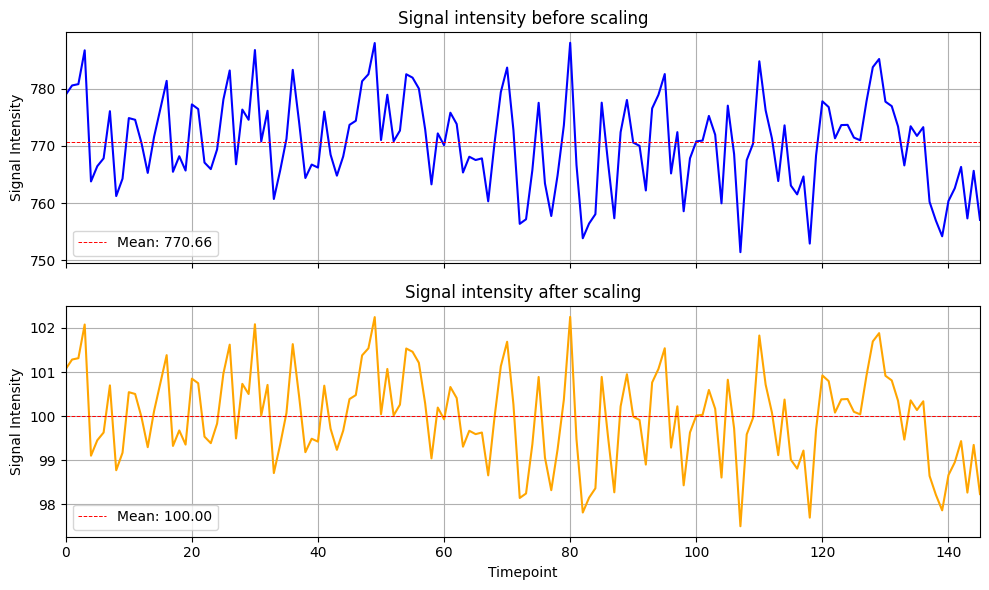

In [20]:
blur_nii = nib.load("./afni_processing/sub_08.results/pb03.sub_08.r01.blur.nii.gz").get_fdata()
scale_nii = nib.load("./afni_processing/sub_08.results/pb04.sub_08.r01.scale.nii.gz").get_fdata()

# Choose a voxel (e.g., center)
x, y, z = blur_nii.shape[0]//2, blur_nii.shape[1]//2, blur_nii.shape[2]//2
time_series1 = blur_nii[x, y, z, :]
time_series2 = scale_nii[x, y, z, :]
n_timepoints = time_series1.shape[0]

# Calculate the means of the time series
mean_time_series1 = time_series1.mean()
mean_time_series2 = time_series2.mean()

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axs[0].plot(time_series1, color='blue')
axs[0].set_title("Signal intensity before scaling")
axs[0].set_ylabel("Signal Intensity")
axs[0].axhline(mean_time_series1, color='red', linestyle='--', linewidth=0.7, label=f"Mean: {mean_time_series1:.2f}")
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlim(0, n_timepoints - 1)

axs[1].plot(time_series2, color='orange')
axs[1].set_title("Signal intensity after scaling")
axs[1].set_xlabel("Timepoint")
axs[1].set_ylabel("Signal Intensity")
axs[1].axhline(mean_time_series2, color='red', linestyle='--', linewidth=0.7, label=f"Mean: {mean_time_series2:.2f}")
axs[1].grid(True)
axs[1].legend()
axs[0].set_xlim(0, n_timepoints - 1)

plt.tight_layout()
plt.show()

## Results: Checking Preprocessing
Let's have a look at the results directory. The files containing the **pb** string are the preprocessed functional images at each preprocessing step, and the files with the **T1w** string are the preprocessed anatomical images. Auxiliary functional images are created to assist with specific preprocessing steps, and auxiliary text files contain information about transformation matrices and movement parameter:

In [21]:
!ls ./afni_processing/sub_08.results

@epi_review.sub_08			 pb01.sub_08.r01.tshift+orig.HEAD
anat_final.sub_08+tlrc.BRIK		 pb01.sub_08.r02.tshift+orig.BRIK
anat_final.sub_08+tlrc.HEAD		 pb01.sub_08.r02.tshift+orig.HEAD
anat_w_skull_warped+tlrc.BRIK		 pb02.sub_08.r01.volreg+tlrc.BRIK
anat_w_skull_warped+tlrc.HEAD		 pb02.sub_08.r01.volreg+tlrc.HEAD
dfile.r01.1D				 pb02.sub_08.r02.volreg+tlrc.BRIK
dfile.r02.1D				 pb02.sub_08.r02.volreg+tlrc.HEAD
dfile_rall.1D				 pb03.sub_08.r01.blur+tlrc.BRIK
final_epi_vr_base_min_outlier+tlrc.BRIK  pb03.sub_08.r01.blur+tlrc.HEAD
final_epi_vr_base_min_outlier+tlrc.HEAD  pb03.sub_08.r01.blur.nii.gz
full_mask.sub_08+tlrc.BRIK		 pb03.sub_08.r02.blur+tlrc.BRIK
full_mask.sub_08+tlrc.HEAD		 pb03.sub_08.r02.blur+tlrc.HEAD
mask_anat.sub_08+tlrc.BRIK		 pb04.sub_08.r01.scale+tlrc.BRIK
mask_anat.sub_08+tlrc.HEAD		 pb04.sub_08.r01.scale+tlrc.HEAD
mask_epi_anat.sub_08+tlrc.BRIK		 pb04.sub_08.r01.scale.nii.gz
mask_epi_anat.sub_08+tlrc.HEAD		 pb04.sub_08.r02.scale+tlrc.BRIK
mask_epi_extents+tlrc.BRIK		 p

<div style="background-color: #ffe5cc; padding: 10px; border-radius: 5px;">
    <div style="background-color: #ff9900; padding: 5px; border-radius: 5px; font-weight: bold;">
        <span style="font-size: 15px; color: #ff9900; background-color: white; border-radius: 50%; width: 20px; height: 20px; display: inline-block; text-align: center; line-height: 20px;">
            !
        </span> <span style="color: white;">Warning:</span>
    </div>
    <p style="margin: 10px 0;">
        In AFNI, a +tlrc extension (and the “Talairach View”) indicates that the image has been normalized. However, this does not necessarily mean the image is in Talairach space. The Talairach label is retained for legacy reasons, ensuring compatibility with older versions of the software. To verify which space the image has been warped to, you can use the <code>3dinfo</code> command and check the “Template Space” field. The three possibilities are: “ORIG” (the image has not been warped), “TLRC” (normalized to Talairach space), and “MNI” (normalized to MNI space).
    </p>
</div>

### Visualizations
To visualize the preprocessing outputs with ipyniivue, the files are first converted to NIfTI format. Once loaded, check whether the functional and anatomical images are properly aligned to MNI space. Misalignments could indicate issues with the preprocessing steps. Smoothed images will generally appear less detailed than the original images due to the blurring effect; this is expected, but they should not be excessively blurry or too sharp. The scaled functional image will have less anatomical definition, as the signal intensity has been normalized across time, making it more uniform across brain voxels. When reviewing the masks, ensure they appropriately cover the brain regions of interest and match the underlying anatomy. For example, the "mask_group" is typically a more liberal mask compared to the "full_mask".

In [22]:
!3dAFNItoNIFTI -prefix ./afni_processing/mni152.nii.gz /cvmfs/neurodesk.ardc.edu.au/containers/afni_21.2.00_20210714/afni_21.2.00_20210714.simg/opt/afni-latest/MNI_avg152T1+tlrc
!3dAFNItoNIFTI -prefix ./afni_processing/sub_08.results/anat_w_skull_warped.nii.gz ./afni_processing/sub_08.results/anat_w_skull_warped+tlrc
!3dAFNItoNIFTI -prefix ./afni_processing/sub_08.results/anat_final.nii.gz ./afni_processing/sub_08.results/anat_final.sub_08+tlrc
!3dAFNItoNIFTI -prefix ./afni_processing/sub_08.results/pb02.sub_08.r01.volreg+tlrc.nii.gz ./afni_processing/sub_08.results/pb02.sub_08.r01.volreg+tlrc
!3dAFNItoNIFTI -prefix ./afni_processing/sub_08.results/full_mask.sub_08+tlrc.nii.gz ./afni_processing/sub_08.results/full_mask.sub_08+tlrc
!3dAFNItoNIFTI -prefix ./afni_processing/sub_08.results/mask_group.nii.gz ./afni_processing/sub_08.results/mask_group+tlrc

++ 3dAFNItoNIFTI: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
++ 3dAFNItoNIFTI: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
++ 3dAFNItoNIFTI: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
++ 3dAFNItoNIFTI: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
*+ WARNING: varying brick factors, writing NIfTI as float
++ 3dAFNItoNIFTI: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
++ 3dAFNItoNIFTI: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]


In [23]:
# Paths to files
anat_skull = './afni_processing/sub_08.results/anat_w_skull_warped.nii.gz'
anat_final = './afni_processing/sub_08.results/anat_final.nii.gz'
volreg_func = './afni_processing/sub_08.results/pb02.sub_08.r01.volreg+tlrc.nii.gz'
mni_nifti = './afni_processing/mni152.nii.gz'
smoothed = './afni_processing/sub_08.results/pb03.sub_08.r01.blur.nii.gz'
scaled = './afni_processing/sub_08.results/pb04.sub_08.r01.scale.nii.gz'
full_mask = './afni_processing/sub_08.results/full_mask.sub_08+tlrc.nii.gz'
group_mask = './afni_processing/sub_08.results/mask_group.nii.gz'

In [24]:
nv = NiiVue()

# Paths to all volumes
volumes = [
    {"path": mni_nifti, "colormap": "gray", "opacity": 1.0},  # MNI background
    {"path": anat_final, "colormap": "red", "opacity": 1.0},  # default overlay
    {"path": volreg_func, "colormap": "red", "opacity": 0.0},
    {"path": smoothed,  "opacity": 0.0},
    {"path": scaled, "opacity": 0.0},
    {"path": full_mask,  "opacity": 0.0},
    {"path": group_mask,  "opacity": 0.0},
]

# Load all volumes into viewer
nv.load_volumes(volumes)

# Dropdown options
overlay_dropdown = widgets.Dropdown(
    options=[
        ("Anatomical aligned to MNI", 1),
        ("Motion-corrected functional to MNI", 2),
        ("Smoothed functional (blur)", 3),
        ("Scaled functional (scale)", 4),
        ("Union of functional masks (full_mask)", 5),
        ("Dilated group mask (group_mask)", 6)
    ],
    value=1,
    description='Overlay:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='350px')
)

# Update function
def update_overlay(change):
    selected_idx = change.new

    # Set all overlays to 0 opacity
    for idx in range(1, len(volumes)):
        nv.volumes[idx].opacity = 0.0

    # Activate the selected one
    nv.volumes[selected_idx].opacity = 1.0

    # Hide MNI background if functional data is selected
    nv.volumes[0].opacity = 0.0 if selected_idx in [3, 4] else 1.0

# Attach the observer
overlay_dropdown.observe(update_overlay, names='value')

# Show viewer and dropdown
display(VBox([overlay_dropdown, nv]))